In [13]:
import numpy as np
from layers import VecInt
from scipy.ndimage import distance_transform_edt as bwdist
import torch


class SourceWarpPoint:
    def __init__(self, point, decay_power=1, deformation_magnitude=6):

        # Default values
        self.decay_power = decay_power
        self.deformation_magnitude = deformation_magnitude
        self.point = point

    def print(self):
        print('point: ', self.point, ' decay power: ', self.decay_power,
              ' deformation magnitude: ', self.deformation_magnitude)


class SourceGen:
    """
    Randomly generate source points with:
    n_points: number of source points to drive deformation
    random decay power: min and max value
    deformation magnitude: min and max value
    Source points are randomly located with a given mask (e.g ventricle)
    """
    def __init__(self, n_points, image_shape, decay_power_range=[0.5, 2], deformation_magnitude_range=[1, 5]):
        self.image_shape = image_shape
        self.decay_power_range = decay_power_range
        self.deformation_magnitude_range = deformation_magnitude_range
        self.n_points = n_points

    def run(self, ventricle_mask=None):
        points = []
        sources = []

        if ventricle_mask is None:
            x, y, z = np.meshgrid(np.linspace(0, self.image_shape[0]-1, self.image_shape[0]),
                                  np.linspace(0, self.image_shape[1]-1, self.image_shape[1]),
                                  np.linspace(0, self.image_shape[2]-1, self.image_shape[2]))
        else:
            islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))  # find the slice with the largest masked volume
            mask_center = np.zeros(ventricle_mask.shape)
            mask_center[:, :, islice-5:islice+4] = ventricle_mask[:, :, islice - 5:islice + 4]  # only place sources around ±5 slices from islice
            x, y, z = np.where(mask_center > 0)
            loc = np.where(z == islice)
            # nloc = [loc[0][0],loc[0][-1]]

        index = np.random.randint(len(x), size=self.n_points)
        for i in range(self.n_points):
            points.append([x[index[i]], y[index[i]], z[index[i]]])
            alpha = np.random.uniform(low=self.deformation_magnitude_range[0], high=self.deformation_magnitude_range[1])
            beta_exp = np.random.uniform(low=np.log(self.decay_power_range[0]),
                                         high=np.log(np.minimum(self.decay_power_range[1], np.log2(alpha/(alpha-1)))))
            beta = np.exp(beta_exp)

            sources.append(SourceWarpPoint(point=points[i], decay_power=beta,
                                           deformation_magnitude=alpha*np.random.choice([-1, 1])))
        return sources


class Simulator:
    """
    Simulate a random deformation field based on source model D=a/r^b from multiple source points.

    Returns
    -------
    D : the overall deformation field

    """

    def __init__(self, image_size=[192, 240, 192], int_steps=7):

        self._image_size = image_size
        # self.transformer = SpatialTransformer(image_size, mode=interp_method)
        self.vectint = VecInt(image_size, int_steps)  # square and scaling layer for exponentiation

    def simulate(self, sources, brain_mask=None, thresh=30):
        """
        sources: sources to drive deformation, generated from SourceGen
        brain_mask: optional mask of the brain region, deformation outside is set to 0
        thresh: a threshold of the distance to the brain boundary (value above thresh is not affected)
        """
        [X, Y, Z] = np.mgrid[0:self._image_size[0], 0:self._image_size[1], 0:self._image_size[2]]
        D = np.zeros((3, self._image_size[0], self._image_size[1], self._image_size[2]))
        
        for source in sources:
            decay_power = source.decay_power
            deformation_mag = source.deformation_magnitude

            # R2 = np.square((X-source.point[0])*1.5) + np.square((Y-source.point[1])*1.5) + np.square((Z-source.point[2])*1.5)
            R2 = np.square((X-source.point[0])) + np.square((Y-source.point[1])) + np.square((Z-source.point[2]))
            # F = deformation_mag/(np.power(R2, decay_power/2)+1e-6) # deformation magnitude (+retraction,-dilation)
            # F[source.point[0], source.point[1], source.point[2]] = deformation_mag
            
            # DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F
            # DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F
            # DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F

            # D = D + np.stack((DX, DY, DZ), axis=0)
            dist = R2
            R2 = (R2-R2.min())/(R2.max()-R2.min())
            F = deformation_mag*(1-R2)**decay_power 

            DX = (X-source.point[0])/(np.sqrt(dist)+1e-5)*F
            DY = (Y-source.point[1])/(np.sqrt(dist)+1e-5)*F
            DZ = (Z-source.point[2])/(np.sqrt(dist)+1e-5)*F
            D = D + np.stack((DX, DY, DZ), axis=0)

        if brain_mask is not None:  # set deformation outside the brain to 0 with smooth transitions
            brain_dist = bwdist(brain_mask) / 30
            brain_dist[brain_dist > 1] = 1
            D = np.multiply(D, np.repeat(brain_dist[np.newaxis, :, :], 3, axis=0))

        # D = self.vectint(torch.from_numpy(D).unsqueeze(0).float())
        return torch.from_numpy(D).unsqueeze(0).float()



# if __name__ == '__main__':
#     sources = [
#         SourceWarpPoint(point=[120,90,101]),
#         SourceWarpPoint(point=[112,144,101]),
#         SourceWarpPoint(point=[85,140,90], deformation_magnitude=20),
#     ]
#
#     # Instantiate the Warping Transform
#     transform = WarpTransform()


In [14]:
import os
import torch
import matplotlib.pyplot as plt
from layers import SpatialTransformer
import numpy as np
import nibabel as nib

from skimage.transform import resize
from scipy.ndimage.interpolation import affine_transform

from deformation_simulator import Simulator, SourceGen
from helpers import normalizeImage, random_transform

folder = "/mnt/blackhole-data2/RadOnc_Brain"
write_dir = "/home/myi16/jsr_Y/sample data/Murong"

CT_min = -100.0
CT_max = 100.0
CBCT_min = -100.0
CBCT_max = 100.0
T1_min = -100.0
T1_max = 2300.0
config = dict()

config['image_size'] = [128, 160, 128]
config['num_samples'] = 10
config['augment_translation'] = 5
config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] = [1, 2]  # [1e-2,1e-1] # decay power range in deformation simulation
config['augment_deformation_range'] = [1.5, 2.5]  # deformation magnitude range in deformation simulation

# load synthesis generator

indices = np.arange(1, 6)
n_moving = []
n_fixed = []
n_cbct = []
n_mask_ventricle = []
n_mask_brain = []
for i in indices:
    n_fixed.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CT-crop-resampled.nii")).get_fdata())
    n_cbct.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CBCT_OArm-crop-resampled.nii")).get_fdata())
    n_moving.append(nib.load(os.path.join(folder, f"NormalAnatomy", f"atlas_brain_{i:02}_T1-crop-resampled.nii")).get_fdata())
    n_mask_ventricle.append(np.squeeze(nib.load(os.path.join(folder, f"MALPEM-MR-Brain-Segmentations",
                                                             f"atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz")).get_fdata()))
    n_mask_brain.append(nib.load(os.path.join(folder, f"NormalAnatomy_Mask", f"atlas_brain_{i:02}_brain_mask.nii.gz")).get_fdata())

    




In [3]:
mr_list=[]
mr_deform_list=[]
flow_list = []
for i in range(config['num_samples']):
    index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    simulator = Simulator(image_size=n_moving[index].shape)
    original_shape = n_moving[index].shape
    transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
    transformer_nearest = SpatialTransformer(original_shape, mode='nearest')
    ct = n_fixed[index]
    mr = n_moving[index]
    cbct = n_cbct[index]
    mask_ventricle = n_mask_ventricle[index]
    mask_brain = n_mask_brain[index]

    # Apply rigid transformation
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen = SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    # ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    # ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    # cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    # cbct_deform = transformer_linear(cbct, flow)
    # mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    # mask_deform = transformer_nearest(mask, flow)

    # # Resize images/masks to target size
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)
    mr_list.append(mr)
    mr_deform_list.append(mr_deform)
    flow_list.append(flow)

    # ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    # ct = normalizeImage(ct, CT_max, CT_min)
    # ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    # ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    # cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    # cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    # cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    # cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    # mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    # mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

# Define subsampling factors to reduce the size of the quiver plot







    # Save to file
    # torch.save(mr,os.path.join(write_dir, f"mr_{i:03}.pt"))
    # torch.save(flow,os.path.join(write_dir, f"flow_{i:03}.pt"))



/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
import SimpleITK as sitk
for i in range(1):
    mr = torch.load('/home/myi16/jsr_Y/sample data/Runze/mr000.pt')
    index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    simulator = Simulator(image_size=mr.shape)
    original_shape = mr.shape
    transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
    transformer_nearest = SpatialTransformer(original_shape, mode='nearest')
    # ct = n_fixed[index]
    # mr = n_moving[index]
    # cbct = n_cbct[index]
    # mask_ventricle = n_mask_ventricle[index]
    # mask_brain = n_mask_brain[index]

    # Apply rigid transformation
    # T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    # ct = affine_transform(ct, T, mode='nearest')
    # mr = affine_transform(mr, T, mode='nearest')
    # cbct = affine_transform(cbct, T, mode='nearest')
    # mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    # mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen = SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    # ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    # ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    # cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    # cbct_deform = transformer_linear(cbct, flow)
    # mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    # mask_deform = transformer_nearest(mask, flow)

    # # Resize images/masks to target size
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)

    mr_def_img = sitk.GetImageFromArray(mr_deform)
    flow_img = sitk.GetImageFromArray(flow.numpy())
    flow_img.SetSpacing([0.7,0.7,1])
    mr_img = sitk.GetImageFromArray(mr)
    flow_runze = sitk.GetImageFromArray(torch.load('/home/myi16/jsr_Y/sample data/Runze/mr000.pt'))

    sitk.WriteImage(mr_def_img, '/home/myi16/jsr_Y/sample data/Runze/mr000.mha')
    sitk.WriteImage(flow_runze, '/home/myi16/jsr_Y/sample data/Runze/flow000.mha')
    sitk.WriteImage(mr_def_img, '/home/myi16/jsr_Y/sample data/Runze/def_mymr000.mha')
    sitk.WriteImage(flow_img, '/home/myi16/jsr_Y/sample data/Runze/myflow000.mha')

    # ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    # ct = normalizeImage(ct, CT_max, CT_min)
    # ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    # ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    # cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    # cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    # cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    # cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    # mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    # mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

# Define subsampling factors to reduce the size of the quiver plot







    # Save to file
    # torch.save(mr,os.path.join(write_dir, f"mr_{i:03}.pt"))
    # torch.save(flow,os.path.join(write_dir, f"flow_{i:03}.pt"))



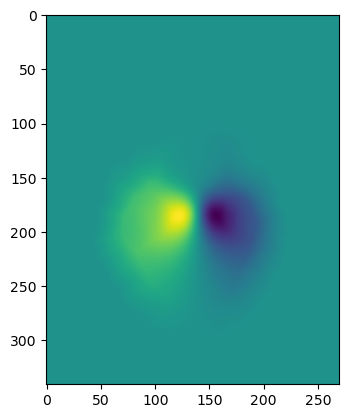

In [15]:
plt.imshow(flow[0,0,:,:,72].T)